In [2]:
"""
Construct a real HDF5 file from the real dataset (RT-1-X)
"""

#load the dataset
import os
os.environ['CURL_CA_BUNDLE'] = '/etc/ssl/certs/ca-bundle.crt'
import tensorflow as tf 
import tensorflow_datasets as tfds
import tqdm
import h5py
import numpy as np
# load raw dataset --> replace this with tfds.load(<dataset_name>) on your
# local machine!
# dataset_name = 'bc_z'
dataset_name_list = ['fractal20220817_data',
'bridge',
'taco_play',
'jaco_play',
'roboturk',
'viola',
'berkeley_autolab_ur5',
'language_table',
'stanford_hydra_dataset_converted_externally_to_rlds',
'maniskill_dataset_converted_externally_to_rlds',
'ucsd_kitchen_dataset_converted_externally_to_rlds',
'ucsd_pick_and_place_dataset_converted_externally_to_rlds',
'bc_z',
'berkeley_rpt_converted_externally_to_rlds',
'kaist_nonprehensile_converted_externally_to_rlds',
'stanford_mask_vit_converted_externally_to_rlds',
'asu_table_top_converted_externally_to_rlds',
'stanford_robocook_converted_externally_to_rlds',
'iamlab_cmu_pickup_insert_converted_externally_to_rlds',
'berkeley_fanuc_manipulation',
'cmu_food_manipulation',
'cmu_play_fusion',
'berkeley_gnm_recon']

# dataset_meta = [
#     {'name':'fractal20220817_data',
#     'img_key': ['observation','image'],
#     'lang_key': ['observation','natural_language_instruction']
#     },
#    {'name' :'bc_z',
#     'img_key': ['observation','image'],
#     'lang_key': ['observation','natural_language_instruction']
#     },
#     {'name' :'jaco_play',
#     'img_key': ['observation','image'],
#     'lang_key': ['observation','natural_language_instruction']
#     }
# ]

dataset_meta = [
    {'name':'bridge:1.0.0',
    'img_key': ['observation','image_0'],
    'lang_key': ['language_instruction']
    },
   {'name' :'cmu_play_fusion',
    'img_key': ['observation','image'],
    'lang_key': ['language_instruction']
    },
    {'name' :'jaco_play',
    'img_key': ['observation','image'],
    'lang_key': ['observation','natural_language_instruction']
    }
]

data_dir= '/data/home/acw694/CLIPort_new_loss/scratch/tensorflow_datasets'

# Take just take the first and the last step
def episode2steps(episode):
    return episode['steps']

def filter_first_last_terminal(step):
    return step['is_first'] or step['is_terminal']

def step_map_fn(step):
    return {
        'observation': {
            'image': step['observation']['image'],
            'language': step['observation']['natural_language_instruction'],
        }   
    }

def append_or_create_dataset(f, name, data, dtype=None):

    if name in f:
        # If dataset already exists, append to it
        dset = f[name]
        dset.resize(dset.shape[0] + len(data), axis=0)
        dset[-len(data):] = data
        n = len(dset)

    else:
        if dtype is None:
            maxshape = (None,) + data[0].shape
            chunks = (1,) + data[0].shape
            f.create_dataset(name, data=data, maxshape=maxshape,
                                chunks=chunks)
        else:
            maxshape = (None,)
            chunks = (1,)  # For variable-length data
            f.create_dataset(name, data=data, maxshape=maxshape,
                                chunks=chunks, dtype=dtype)

        n = len(data)

    return n

def get_nested_value(data, keys):
    value = data
    for key in keys:
        value = value[key]  # 一层一层向下访问
    return value

2024-09-27 18:19:21.884669: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 18:19:22.753199: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-27 18:19:24.033000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 18:19:24.033087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 18:19:24.208670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
for data in dataset_meta:
    print(data)

{'name': 'bridge:1.0.0', 'img_key': ['observation', 'image_0'], 'lang_key': ['language_instruction']}
{'name': 'cmu_play_fusion', 'img_key': ['observation', 'image'], 'lang_key': ['language_instruction']}
{'name': 'jaco_play', 'img_key': ['observation', 'image'], 'lang_key': ['observation', 'natural_language_instruction']}


In [4]:
data = dataset_meta[0]
dataset_name = data['name']
lang_key = data['lang_key']
image_key = data['img_key']

data_s1 = []
data_s2 = []
data_language = []
#f = h5py.File(os.path.join('/data/home/acw694/CLIPort_new_loss/scratch/data_hdf5',
#                                'real_img.hdf5'), 'a')
# load the dataset
ds, ds_info = tfds.load(
    dataset_name, data_dir = data_dir, download=False, split='train', with_info=True)
print(f"Successfully load dataset: {dataset_name}")

# first map to steps
ds_steps = ds.map(
    episode2steps, num_parallel_calls=tf.data.AUTOTUNE).flat_map(lambda x: x)

# then filtered out the first and the last image
filtered_ds = ds_steps.filter(filter_first_last_terminal)
filtered_ds = filtered_ds.as_numpy_iterator()

current_first_instruction = None
current_first_image = None

Successfully load dataset: bridge:1.0.0


In [5]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def resize_and_crop_longest_edge(image, target_height=320, target_width=160):

    input_height, input_width = image.shape[:2]
    
    # rotate if width > height
    if input_width > input_height:
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    input_height, input_width = image.shape[:2]
    
    # scale iamge if the height is less than target height
    if input_height < target_height:
        scale_factor = target_height / input_height
        new_width = int(input_width * scale_factor)
        new_height = target_height
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    cropped_image = center_crop(image, target_height, target_width)
    
    return cropped_image 

def center_crop(image, target_height, target_width):
    input_height, input_width = image.shape[:2]
    
    # Calculate the coordinates for cropping
    start_x = (input_width - target_width) // 2
    start_y = (input_height - target_height) // 2
    
    # Ensure the coordinates are within bounds
    start_x = max(start_x, 0)
    start_y = max(start_y, 0)
    
    cropped_image = image[start_y:start_y + target_height, start_x:start_x + target_width]
    
    return cropped_image

In [6]:
def resize_and_crop_longest_edge_cv2(image, target_height=320, target_width=160):
    
    # 获取输入图像的高度和宽度
    input_height, input_width = image.shape[:2]
    
     # rotate if width > height
    if input_width > input_height:
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    input_height, input_width = image.shape[:2]
    
    # 计算目标的宽高比
    target_aspect_ratio = target_width / target_height
    input_aspect_ratio = input_width / input_height

    # 先根据最长边调整大小，保持宽高比不变
    if input_aspect_ratio > target_aspect_ratio:
        # 图像相对较宽，先调整宽度到目标宽度
        new_width = target_width
        new_height = int(input_height * (target_width / input_width))  # 按比例调整高度
    else:
        # 图像相对较高，先调整高度到目标高度
        new_height = target_height
        new_width = int(input_width * (target_height / input_height))  # 按比例调整宽度

    # 使用 OpenCV 的 resize 方法，保持宽高比
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # 获取调整后图像的高度和宽度
    current_height, current_width = resized_image.shape[:2]
    
    # 居中裁剪到目标大小（如果调整后图像比目标尺寸大）
    if current_height > target_height:
        start_h = (current_height - target_height) // 2
        resized_image = resized_image[start_h:start_h + target_height, :]
    if current_width > target_width:
        start_w = (current_width - target_width) // 2
        resized_image = resized_image[:, start_w:start_w + target_width]

    # 如果裁剪后的尺寸小于目标尺寸，进行填充
    pad_height = max(target_height - resized_image.shape[0], 0)
    pad_width = max(target_width - resized_image.shape[1], 0)

    # 使用 cv2.copyMakeBorder 进行填充
    padded_image = cv2.copyMakeBorder(
        resized_image,
        pad_height // 2, pad_height - pad_height // 2,
        pad_width // 2, pad_width - pad_width // 2,
        cv2.BORDER_CONSTANT, value=[0, 0, 0]  # 填充黑色
    )

    return padded_image




[nltk_data] Downloading package words to
[nltk_data]     /data/home/acw694/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [8]:
ds_info

tfds.core.DatasetInfo(
    name='bridge_dataset',
    full_name='bridge_dataset/1.0.0',
    description="""
    TODO(example_dataset): Markdown description of your dataset.
    Description is **formatted** as markdown.
    
    It should also contain any processing which has been applied (if any),
    (e.g. corrupted example skipped, images cropped,...):
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/bridge_dataset',
    data_dir='/data/home/acw694/CLIPort_new_loss/scratch/tensorflow_datasets/bridge/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=123.39 GiB,
    features=FeaturesDict({
        'episode_metadata': FeaturesDict({
            'episode_id': Scalar(shape=(), dtype=int32),
            'file_path': Text(shape=(), dtype=string),
            'has_image_0': Scalar(shape=(), dtype=bool),
            'has_image_1': Scalar(shape=(), dtype=bool),
            'has_image_2': Scalar(shape=(), dtype=bool),
            'has_image_3':

find last!
b'fold the cloth from bottom left to top right'
True
True
b'fold the cloth from bottom left to top right'
b'fold the cloth from bottom left to top right'


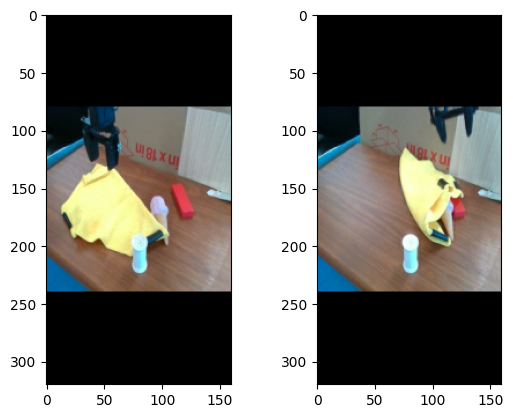

In [53]:
batch = next(filtered_ds)
if batch['is_first']:
    current_first_instruction = get_nested_value(batch, lang_key)
    current_first_image = get_nested_value(batch, image_key)
    print('find first!')
    print(current_first_instruction)

elif current_first_instruction and batch['is_last']:
    last_instruction = get_nested_value(batch, lang_key)
    last_image = get_nested_value(batch, image_key)
    print('find last!')
    print(last_instruction)
    
    print(is_valid_language(current_first_instruction))
    print(is_valid_language(last_instruction))

    #Add them to our lists
    plt.subplot(1,2,1)
    plt.imshow(resize_and_crop_longest_edge_cv2(current_first_image))
    plt.subplot(1,2,2)
    plt.imshow(resize_and_crop_longest_edge_cv2(last_image))
    
    print(current_first_instruction)
    print(last_instruction)

    current_first_instruction = None
    current_first_image = None

else:
    import warnings
    warnings.warn("Skipping.")



In [71]:
batch

{'action': array([0., 0., 0., 0., 0., 0., 1.], dtype=float32),
 'discount': 1.0,
 'is_first': False,
 'is_last': True,
 'is_terminal': True,
 'language_embedding': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

NameError: name 'first_image' is not defined

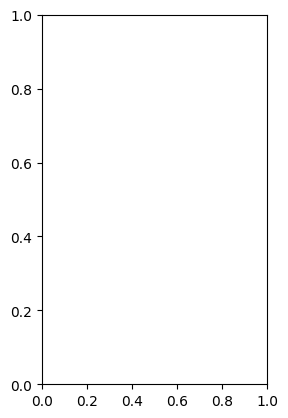

In [7]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(first_image)
plt.subplot(1,2,2)
plt.imshow(last_image)

In [213]:
ds_steps = ds_steps.as_numpy_iterator()

AttributeError: 'NumpyIterator' object has no attribute 'as_numpy_iterator'

b'close middle drawer'


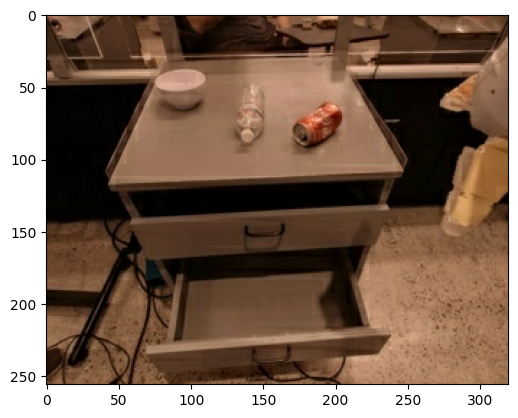

In [329]:
batch = next(ds_steps)
current_first_instruction = get_nested_value(batch, lang_key)
current_first_image = get_nested_value(batch, image_key)
print(current_first_instruction)
plt.imshow(current_first_image)



In [330]:
batch

{'action': {'base_displacement_vector': array([0., 0.], dtype=float32),
  'base_displacement_vertical_rotation': array([0.], dtype=float32),
  'gripper_closedness_action': array([1.], dtype=float32),
  'rotation_delta': array([-0.,  0., -0.], dtype=float32),
  'terminate_episode': array([0, 1, 0], dtype=int32),
  'world_vector': array([5.551115e-17, 0.000000e+00, 0.000000e+00], dtype=float32)},
 'is_first': False,
 'is_last': False,
 'is_terminal': False,
 'observation': {'base_pose_tool_reached': array([ 0.4383234 , -0.21608683,  0.9783297 , -0.6029693 ,  0.7801606 ,
         -0.03705525,  0.16249429], dtype=float32),
  'gripper_closed': array([0.], dtype=float32),
  'gripper_closedness_commanded': array([0.], dtype=float32),
  'height_to_bottom': array([0.9783297], dtype=float32),
  'image': array([[[164, 130,  93],
          [166, 128,  92],
          [174, 127,  97],
          ...,
          [ 84,  48,  24],
          [ 81,  46,  26],
          [ 82,  50,  29]],
  
         [[115, 